In [65]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from utils_data_structures import col_prefixes

In [66]:
# large_grouped_sorare_data.csv was doing better on training, but worse on predicting
grouped_df = pd.read_csv('sorare_data/small_test_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)

print(grouped_df['So_5_Scores_9'].isna().sum())

0


In [67]:
defenders_df = grouped_df[grouped_df['Position'] == 'Defender']
defenders_df = defenders_df.drop(columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club'])



In [68]:
defenders_df.dtypes.value_counts()

float64    308
int64        4
Name: count, dtype: int64

In [69]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = defenders_df.drop(columns=columns_to_drop)
y = defenders_df[target_column]


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=750, learning_rate=0.01, max_depth=3, subsample=0.6, colsample_bytree=0.8, gamma=0.1, reg_alpha= 1.0, reg_lambda= 100.0 , random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
y_pred_xgb_clipped = np.clip(y_pred_xgb, 0, 100)
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_xgb_clipped)
print(f'r2: {r2}')

RMSE: 20.849249849776548
r2: 0.41760107566411897


In [72]:
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42, 
)

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_lgmb_clipped)
print(f'r2: {r2}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 125
[LightGBM] [Info] Start training from score 30.007091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [73]:

# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred_en = elastic_model.predict(X_test)

# Evaluate
y_pred_en_clipped = np.clip(y_pred_en, 0, 100)
mse = mean_squared_error(y_test, y_pred_en_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')



RMSE: 29.048774955267493
r2: -0.1305644903766625


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e+04, tolerance: 1.434e+01
  model = cd_fast.enet_coordinate_descent(


In [74]:
with open('sorare_models/defenders_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
    print("XGB Model saved successfully!")
with open('sorare_models/defenders_lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
    print("LGBM Model saved successfully!")

with open('sorare_models/defenders_elastic_model.pkl', 'wb') as file:
    pickle.dump(elastic_model, file)
    print("Elastic Model saved successfully!")

print("Models saved successfully!")

XGB Model saved successfully!
LGBM Model saved successfully!
Elastic Model saved successfully!
Models saved successfully!


In [75]:
y_test_df = pd.DataFrame(y_test)
y_test_df['XBG_Predictions'] = y_pred_xgb_clipped
y_test_df['LGBM_Predictions'] = y_pred_lgmb_clipped
y_test_df['EN_Predictions'] = y_pred_en_clipped
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions
54,0.00,8.002139,9.344314,6.926901
300,0.00,3.688892,1.961377,8.279927
391,0.00,4.330742,4.757242,4.940578
467,30.04,37.859390,51.783749,1.073656
692,88.92,45.114410,47.209939,12.661095
383,44.84,16.700039,14.963587,0.000000
262,44.98,13.716515,14.387804,8.662830
352,65.26,45.448936,53.841533,70.784013
559,0.00,4.195339,1.908371,0.000000
585,0.00,14.167676,16.951596,0.000000


In [76]:
y_test_df['Average_Prediction'] = (y_test_df['XBG_Predictions'] + y_test_df['LGBM_Predictions'] + y_test_df['EN_Predictions']) / 3
y_test_df = y_test_df[(y_test_df['So_5_Scores_9'] <= 55) & (y_test_df['So_5_Scores_9'] >= 5)]
y_test_df
pd.set_option('display.max_columns', None)
# defenders_df.iloc[[4544]]

In [77]:
y_true = y_test_df['So_5_Scores_9'].to_numpy()
y_pred = y_test_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')

RMSE: 20.696912304727043
r2: -0.1305644903766625


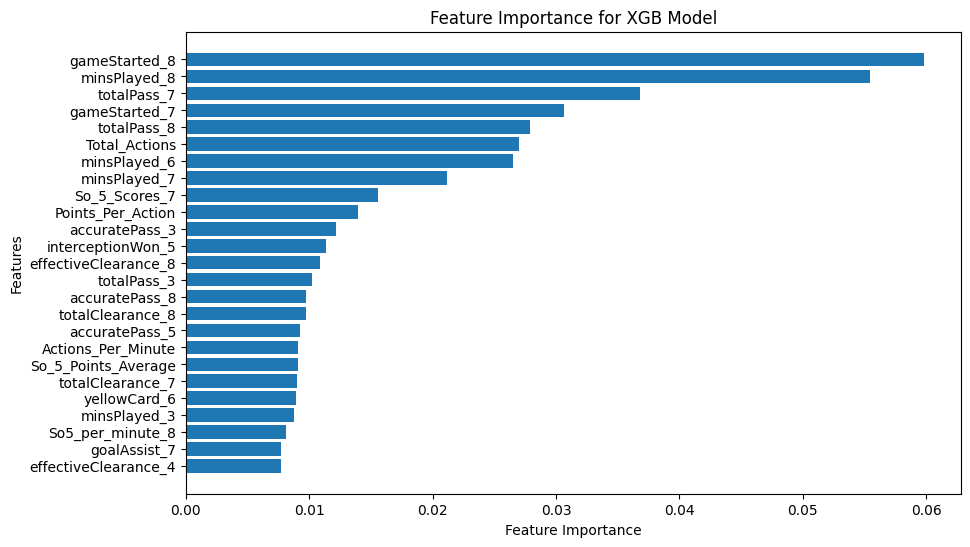

In [78]:

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')
plt.gca().invert_yaxis()
plt.show()

In [79]:
epl_teams = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

epl_teams = epl_teams.fillna(0.0)

epl_defenders_df = epl_teams[epl_teams['Position'] == 'Defender']

epl_defenders_df = epl_defenders_df.reset_index(drop=True)

In [80]:
drop_columns = columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club']

columns_to_drop = [f'{col}_9' for col in col_prefixes]
columns_to_drop.extend(drop_columns)

target_column = 'So_5_Scores_9'

X_test_defenders = epl_defenders_df.drop(columns=columns_to_drop)
y_test_defenders = epl_defenders_df[target_column]

In [81]:
with open('sorare_models/defenders_xgb_model.pkl', 'rb') as file:
    defenders_xgb_model_loaded = pickle.load(file)
    print("XGB Model loaded successfully!")
with open('sorare_models/defenders_lgbm_model.pkl', 'rb') as file:
    defenders_lgbm_model_loaded = pickle.load(file)
    print("LGBM Model loaded successfully!")
with open('sorare_models/defenders_elastic_model.pkl', 'rb') as file:
    defenders_elastic_model_loaded = pickle.load(file)
    print("Elastic Model loaded successfully!")

XGB Model loaded successfully!
LGBM Model loaded successfully!
Elastic Model loaded successfully!


In [82]:
xgb_predictions = defenders_xgb_model_loaded.predict(X_test_defenders)
lgbm_predictions = defenders_lgbm_model_loaded.predict(X_test_defenders)
elastic_predictions = defenders_elastic_model_loaded.predict(X_test_defenders)

xgb_predictions = np.clip(xgb_predictions, 0, 100)
lgbm_predictions = np.clip(lgbm_predictions, 0, 100)
elastic_predictions = np.clip(elastic_predictions, 0, 100)

y_test_defenders_df = pd.DataFrame(y_test_defenders)

epl_defenders_df['sorare_xgb_predictions'] = pd.Series(xgb_predictions)
epl_defenders_df['sorare_lgbm_predictions'] = pd.Series(lgbm_predictions)
epl_defenders_df['sorare_elastic_predictions'] = pd.Series(elastic_predictions)

epl_defenders_df['sorare_predictions'] = epl_defenders_df[['sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].mean(axis=1)

epl_defenders_df[['So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].head(3)

,So_5_Scores_9,sorare_xgb_predictions,sorare_lgbm_predictions,sorare_elastic_predictions
0,0.00,32.748196,20.772603,15.906234
1,0.00,3.452877,0.152709,0.338345
2,34.16,44.813881,42.480926,33.240356


In [83]:
y_true = epl_defenders_df['So_5_Scores_9'].to_numpy() 
y_pred = epl_defenders_df['sorare_predictions'].to_numpy()

# Calculate r2
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_true, y_pred)
print(f'r2: {r2}')

RMSE: 16.887681557906195
r2: 0.6390400076987215


In [84]:
xgb_scores = cross_val_score(defenders_xgb_model_loaded, X, y)
lgbm_scores = cross_val_score(defenders_lgbm_model_loaded, X, y)
elastic_scores = cross_val_score(defenders_elastic_model_loaded, X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 125
[LightGBM] [Info] Start training from score 33.647305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.208e+04, tolerance: 1.460e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.052e+04, tolerance: 1.428e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might

In [85]:
print("XGBoost scores:", xgb_scores)
print("Mean XGBoost score:", xgb_scores.mean())

print("LGBM scores:", lgbm_scores)
print("Mean LGBM score:", lgbm_scores.mean())

print("Elastic scores:", elastic_scores)
print("Mean Elastic score:", elastic_scores.mean())

XGBoost scores: [-0.15347706  0.124272    0.49613852  0.35432575  0.4321945 ]
Mean XGBoost score: 0.2506907429236297
LGBM scores: [-0.39073199  0.00558936  0.46770269  0.35548168  0.4322108 ]
Mean LGBM score: 0.17405050939344818
Elastic scores: [-1.1048605  -0.76705898 -0.27125948 -0.33632807 -0.19703646]
Mean Elastic score: -0.5353086957575162


In [86]:
saved_defenders_df = epl_defenders_df[['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club','So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions', 'sorare_predictions']]
# saved_defenders_df.to_csv('sorare_data/predictions/sorare_defenders_predictions.csv', index=False)